# Read the preprocessed Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
df=pd.read_csv("../../Data/ml-latest-small/PreprocessedData_ml_latest_year_small.csv")
df.head()

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995


# Load Recommender System Class and other important Functions

In [2]:
%run Functions.ipynb 

# Further Processing the Data 

In [3]:
#making all titles lower case
#df["title"] = df["title"].str.lower()

In [4]:
#df.head()

In [5]:
#df.shape

In [6]:
#len(df.movieId.unique())

In [7]:
#len(df.userId.unique())

# Collaborative Filtering (CF)

The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context.

## Model 1: Collaborative Filtering, item-item, K-means

In this approach, CF models are developed using **machine learning algorithms** to predict user’s rating of unrated items. 

> We will use **Surprise**
>> Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.



### 1. Load Surprise Data from DataFrame, Train-Test Split

In [8]:
from surprise import accuracy
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise.model_selection import train_test_split,cross_validate,RandomizedSearchCV
from surprise import KNNWithMeans
from surprise import KNNBasic
reader = Reader()

df_imp=df.drop(['title','year','genres'],axis=1)

surprise_data = Dataset.load_from_df(df_imp, reader)
trainset, testset = train_test_split(surprise_data, test_size=.25,random_state=10)

In [9]:
def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

### 2. Find Optimal k using RandomizedSearchCV

In [10]:
sim_options = {
    "name": ["cosine", "pearson", "pearson_baseline"],"user_based": [False]
}
params = { 'k': range(2,25,1),'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_data)

{'rmse': 0.8824986197029745}
{'rmse': {'k': 22, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fe7846fdbe0>}


### 3. Build Model using best parameters

In [11]:
knnwithmeans = clf.best_estimator['rmse']

### Recommendation Functions, only for this notebook

> Users and items have a raw id and an inner id. Some methods will use/return a raw id (e.g. the predict() method), while some other will use/return an inner id.

> Raw ids are ids as defined in a rating file or in a pandas dataframe. They can be strings or numbers. Note though that if the ratings were read from a file which is the standard scenario, they are represented as strings. This is important to know if you’re using e.g. predict() or other methods that accept raw ids as parameters.

> On trainset creation, each raw id is mapped to a unique integer called inner id, which is a lot more suitable for Surprise to manipulate. Conversions between raw and inner ids can be done using the to_inner_uid(), to_inner_iid(), to_raw_uid(), and to_raw_iid() methods of the trainset.


In [12]:
def recommend_similar_items(movie_title, df, model, n=5):
        movieId=df[df['title']==movie_title]['movieId'].unique()[0]
        inner_movieId=model.trainset.to_inner_iid(movieId)
        
        movie_neighbours=model.get_neighbors(inner_movieId,n)
        
        df_out=df[df.movieId.isin([model.trainset.to_raw_iid(inner_id)
                       for inner_id in movie_neighbours])]
        
        df_out=Process_Avg_Rating(df_out)
        
        return df_out 

In [13]:
CF_knnwithmeans = collab_filtering_Kmeans_Model(knnwithmeans,trainset,testset)

### 5. Fit, predict and cross-validate

In [14]:
knnwithmeans_rmse,knnwithmeans_recommenddf =CF_knnwithmeans.fit_and_predict(df)

**Fitting the train data...**
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
**Predicting the test data...**
RMSE: 0.8926
**RMSE for the predicted result is 0.893**


In [15]:
knnwithmeans_cv_rmse_cv = CF_knnwithmeans.cross_validate(surprise_data)
mean_cv_RMSE_result = round(knnwithmeans_cv_rmse_cv['test_rmse'].mean(),3)
print('**Mean CV RMSE is ' + str(mean_cv_RMSE_result)  + '**')

**Cross Validating the data...**
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8865  0.8831  0.8876  0.8754  0.8836  0.8832  0.0043  
MAE (testset)     0.6711  0.6718  0.6747  0.6671  0.6733  0.6716  0.0026  
Fit time          10.23   9.94    10.40   10.44   10.68   10.34   0.25    
Test time         6.75    6.79    6.64    6.67    6.45    6.66    0.12    
**Mean CV RMSE is 0.883**


### Model Errors Plot

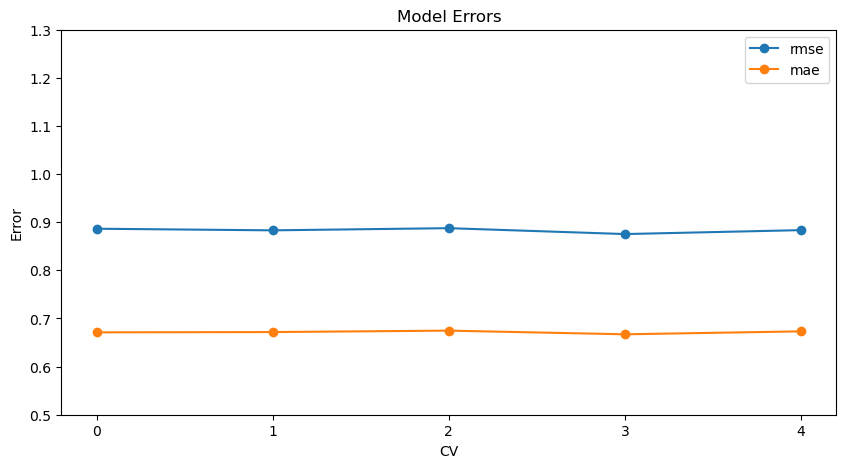

In [16]:
# Get data
rmse = knnwithmeans_cv_rmse_cv['test_rmse']
mae = knnwithmeans_cv_rmse_cv['test_mae']
x = np.arange(len(rmse))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0.5, 1.3)
ax.plot(x, rmse, marker='o', label="rmse")
ax.plot(x, mae, marker='o', label="mae")

# Chart setup
plt.title("Model Errors", fontsize = 12)
plt.xlabel("CV", fontsize = 10)
plt.ylabel("Error", fontsize = 10)
plt.legend()
plt.show()


### 7. Recommend (Item Based)

In [17]:
inp_movie=AskForUserInput(df)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity ma

In [18]:
df_out=recommend_similar_items(inp_movie,df,CF_knnwithmeans.model, n=10)
print("Because You like the movie",inp_movie,"we'd recommend you to watch:")
display(df_out.head(10))

Because You like the movie Toy Story (1995) we'd recommend you to watch:


,,,,average rating,number of ratings
movieId,title,year,genres,,
364,"Lion King, The (1994)",1994,Adventure|Animation|Children|Drama|Musical|IMAX,3.94,172
588,Aladdin (1992),1992,Adventure|Animation|Children|Comedy|Musical,3.79,183
1073,Willy Wonka & the Chocolate Factory (1971),1971,Children|Comedy|Fantasy|Musical,3.87,119
1097,E.T. the Extra-Terrestrial (1982),1982,Children|Drama|Sci-Fi,3.77,122
1270,Back to the Future (1985),1985,Adventure|Comedy|Sci-Fi,4.04,171
2716,Ghostbusters (a.k.a. Ghost Busters) (1984),1984,Action|Comedy|Sci-Fi,3.78,120
2797,Big (1988),1988,Comedy|Drama|Fantasy|Romance,3.72,91
3114,Toy Story 2 (1999),1999,Adventure|Animation|Children|Comedy|Fantasy,3.86,97
8961,"Incredibles, The (2004)",2004,Action|Adventure|Animation|Children|Comedy,3.84,125


### 7. Save Your Model

In [20]:
import pickle
filename = 'Model_2_KNN_Means_ratingbased.sav'
pickle.dump(CF_knnwithmeans, open(filename, 'wb'))